# Part A: IMDb Movie Review Sentiment Analysis

#### Final Report: 
Please check Final Report Part_A_IMDb_Movie_Review_Sentiment_Analysis.docx file.

In [2]:
# Importing Required Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk

from scipy.sparse import hstack

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import RandomizedSearchCV

# 1. Data Exploration and Preprocessing 

#### 1a. Analyze the dataset for trends, missing values and outliers.

In [5]:
# Loading CSV file into a DataFrame
imdb_df = pd.read_csv('data_imdb.csv')

In [6]:
# Displaying the first 5 rows
print(imdb_df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [7]:
# Displaying number of rows and columns present in the dataframe
imdb_df.shape

(50000, 2)

#### 1b. Performing basic data exploration such as checking for missing values

In [9]:
# Checking if there are any null values or missing values present in the dataframe
imdb_df.isnull().sum()

review       0
sentiment    0
dtype: int64

#### Observation:
There are no null values in the dataset.

#### 1c. Identifying if the dataset has balanced or imbalanced classes (positive/negative).

In [12]:
# Checking if the dataset is balanced or not
sentiment_value_counts = imdb_df['sentiment'].value_counts()

# Printing the results
print(sentiment_value_counts)

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


#### Observation: 
Dataset is a balanced dataset as number of positive and negative reviews are same.

#### 1d. Analyzing length of reviews.

In [15]:
# Creating a new column in the DataFrame to store the length of each review by counting words in each review
imdb_df['review_length'] = imdb_df['review'].apply(lambda x: len(x.split())) 

In [16]:
# Displaying the first 5 rows
imdb_df.head()

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


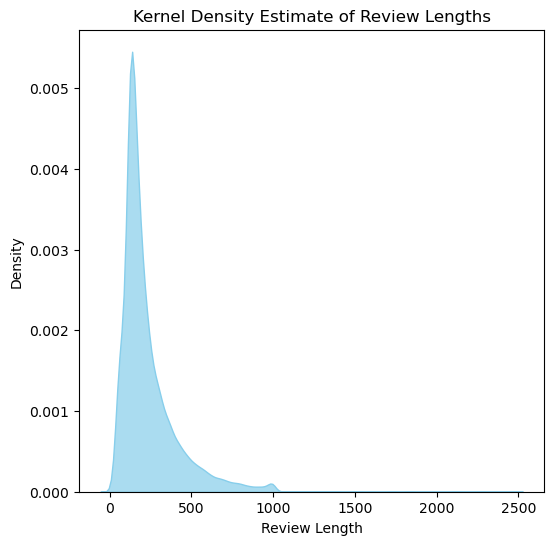

In [17]:
# Plotting Kernel Density Estimation for review_length

plt.figure(figsize=(6, 6))
sns.kdeplot(imdb_df['review_length'], fill=True, color='skyblue', alpha=0.7)

# Adding title and labels
plt.title('Kernel Density Estimate of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Density')

# Displaying the plot
plt.show()

# Observation:
1. Most of the reviews are of length between 50 to 450.
2. Very few reviews have length above 500.
3. The distribution is skewed to the right and shows positive skewness in the distribution of data.

#### 2. Perform data cleaning and text preprocessing.
#### 2a. Removing punctuation, special characters and converting text to lowercase.



In [20]:
# Converting all the reviews to lowercase
imdb_df['review']= imdb_df['review'].str.lower()

In [21]:
# Creating a custom function for removing punctuation and special_characters
# from the review column
def remove_punctuation_special_characters(input_review):
    # Removing special characters and punctuation from the review column
    output_review=re.sub(r'[^a-z\s]','',input_review)
    return output_review

#### 2b. Tokenization of text (splitting text into words).


In [23]:
# Creating function to tokenize review column
def tokenize_text(input_review):
    return word_tokenize(input_review)

#### 2c. Removing extra spaces and stop words from reviews

In [25]:
# Removing "not" word from stopword list. As it might have impact on negative review 
stop_words = set(stopwords.words('english'))
stop_words.discard('not')
print("not" in stop_words)

False


In [26]:
# Creating function to remove stopwords and extra spaces from review column
def remove_extra_spaces_and_stopwords(input_review):
    
    # Removing any extra spaces in each word of the input_review
    input_words = [word.strip() for word in input_review]

    # Removing stopwords from input_review 
    return [word for word in input_words if word not in stop_words]


### 2d. Performing Lemmatization

In [28]:
# Creating function to lemmatize tokenised review
def lemmatizer_tokens(input_review):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in input_review]


In [29]:
# Creating function to join cleaned text into a single string
def join_tokens(input_review):
    return ' '.join(input_review)

In [30]:
# Applying remove_punctuation_special_characters function to dataframe
imdb_df['review']= imdb_df['review'].apply(remove_punctuation_special_characters)

# Applying tokenize_text functions to dataframe
imdb_df['review']= imdb_df['review'].apply(tokenize_text)

# Applying remove_extra_spaces_and_stopwords functions to dataframe
imdb_df['review']= imdb_df['review'].apply(remove_extra_spaces_and_stopwords)

In [31]:
# Applying the lemmatize_tokens functions to dataframe
imdb_df['review']= imdb_df['review'].apply(lemmatizer_tokens)

In [32]:
# Applying join_tokens functions to dataframe
imdb_df['review']= imdb_df['review'].apply(join_tokens)

In [33]:
# Displaying the first 5 rows
imdb_df.head()

,review,sentiment,review_length
0,one reviewer mentioned watching oz episode you...,positive,307
1,wonderful little production br br filming tech...,positive,162
2,thought wonderful way spend time hot summer we...,positive,166
3,basically there family little boy jake think t...,negative,138
4,petter matteis love time money visually stunni...,positive,230


In [34]:
# Initializing LabelEncoder
label_encoder = LabelEncoder()

# Fitting and transforming the sentiment column
imdb_df['sentiment'] = label_encoder.fit_transform(imdb_df['sentiment'])

imdb_df.head()

,review,sentiment,review_length
0,one reviewer mentioned watching oz episode you...,1,307
1,wonderful little production br br filming tech...,1,162
2,thought wonderful way spend time hot summer we...,1,166
3,basically there family little boy jake think t...,0,138
4,petter matteis love time money visually stunni...,1,230


# 2. Feature Engineering

#### 2a. Textual features: Word count, character count, average word length, etc.

In [37]:
# Creating function to count words in each reviews
def word_count(input_review):
    return len(input_review.split())

# Applying word_count function to the 'review' column
imdb_df['word_count'] = imdb_df['review'].apply(word_count)

In [38]:
# Calculating the total number of characters in each reviews
imdb_df['char_count'] = imdb_df['review'].str.len()

In [39]:
# Avoiding division by zero by replacing zero word counts with NaN
imdb_df['avg_word_length'] = imdb_df.apply(lambda row: row['char_count'] / row['word_count'] if row['word_count'] > 0 else None, axis=1)


In [40]:
imdb_df.head()

,review,sentiment,review_length,word_count,char_count,avg_word_length
0,one reviewer mentioned watching oz episode you...,1,307,173,1146,6.624277
1,wonderful little production br br filming tech...,1,162,92,666,7.239130
2,thought wonderful way spend time hot summer we...,1,166,89,590,6.629213
3,basically there family little boy jake think t...,0,138,70,459,6.557143
4,petter matteis love time money visually stunni...,1,230,131,868,6.625954


#### Analysing the word_count column

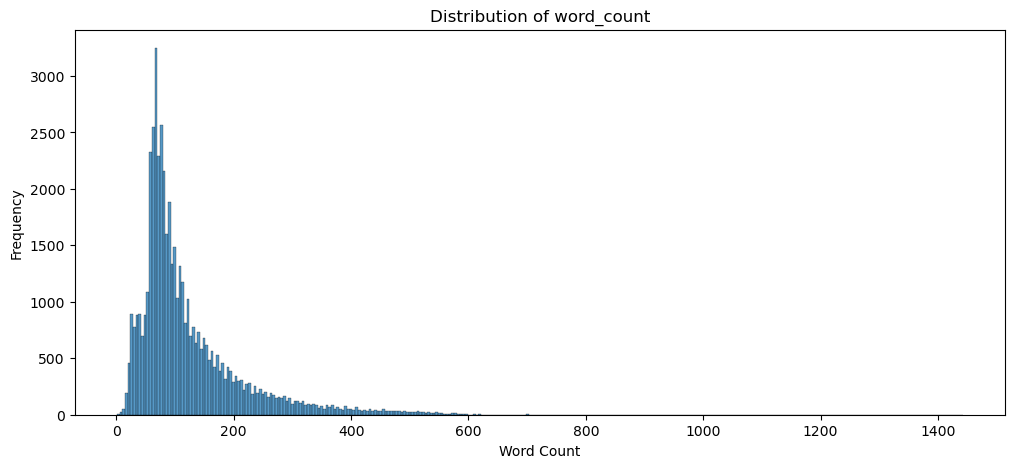

In [42]:
# Creating histogram of the 'word_count' column
plt.figure(figsize=(12, 5))
sns.histplot(data=imdb_df, x="word_count")
plt.title('Distribution of word_count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Observation:
1. Most of the word counts are between 20 to 250.
2. Very few words have count above 400.
3. The distribution is skewed to the right and shows positive skewness in the distribution of data.

#### 2b. Feature extraction using techniques like TF-IDF, Word2Vec, or embeddings.

In [45]:
# Initializing TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.95)

# Fitting and transforming review column
X_tfidf = vectorizer.fit_transform(imdb_df['review'])

#### 2c. Transform the textual data into numerical features that can be used by machine learning models.

In [47]:
# Converting X_tfidf dataFrame for better readability
X_tfidf_array = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
print(X_tfidf_array)

       aaron  abandon  abandoned  abbey  abbott  abc  abducted  ability  able  \
0        0.0      0.0        0.0    0.0     0.0  0.0       0.0      0.0   0.0   
1        0.0      0.0        0.0    0.0     0.0  0.0       0.0      0.0   0.0   
2        0.0      0.0        0.0    0.0     0.0  0.0       0.0      0.0   0.0   
3        0.0      0.0        0.0    0.0     0.0  0.0       0.0      0.0   0.0   
4        0.0      0.0        0.0    0.0     0.0  0.0       0.0      0.0   0.0   
...      ...      ...        ...    ...     ...  ...       ...      ...   ...   
49995    0.0      0.0        0.0    0.0     0.0  0.0       0.0      0.0   0.0   
49996    0.0      0.0        0.0    0.0     0.0  0.0       0.0      0.0   0.0   
49997    0.0      0.0        0.0    0.0     0.0  0.0       0.0      0.0   0.0   
49998    0.0      0.0        0.0    0.0     0.0  0.0       0.0      0.0   0.0   
49999    0.0      0.0        0.0    0.0     0.0  0.0       0.0      0.0   0.0   

       ably  ...  zero  zha

# 3. Model Development 

#### 3a. Build and train classification models to predict the sentiment of reviews.

In [50]:
# Extracting numerical features and target variable
numerical_features = imdb_df[['review_length', 'word_count', 'char_count', 'avg_word_length']].values
y = imdb_df['sentiment'].values

# Combine TF-IDF features with numerical features
X_final = hstack([X_tfidf, numerical_features])


In [51]:
# Splitting Dataset into Train Set and Test Set: (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [52]:
print(X_train.shape)
print(X_test.shape)

(40000, 10004)
(10000, 10004)


In [53]:
# Displaying 5 rows with 10 columns from X_train
X_train_display = X_train[:5, :10].toarray()
print(X_train_display)

[[0.         0.         0.         0.         0.         0.
  0.         0.07534072 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]


In [54]:
# Displaying 5 rows with 10 columns from X_test
X_test_display = X_test[:5, :10].toarray()
print(X_test_display)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.05766457 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]


#### 3b. Experiment with various classification algorithms such as Logistic Regression, Naive Bayes, Support Vector Machine (SVM), 
#### Random Forest, and Neural Networks (e.g., LSTM, BERT, etc.).

#### 1. Logistic Regression

In [58]:
# Building Logistic Regression Model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

C:\Users\meena\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [59]:
# Prediction on X_test using Logistic Regression Model
y_pred_logreg = logreg_model.predict(X_test)

In [60]:
# Evaluating Logistic Regression Model

print("Logistic Regression Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Evaluation:
Accuracy: 0.8657

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      4961
           1       0.86      0.88      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



#### Observations:
With Default values, Logistic Regression Model is performing well on test data with an accuracy of 86.57%. Performing hyperparameter tuning to get better accuracy.

#### Model Tuning: Experiment with different models and tune hyperparameters to optimize performance.

In [63]:
# Parameter list
logreg_param_grid = {'C': [0.01, 1, 10],  
                    'penalty': ['l1', 'l2'], 
                    'solver': ['liblinear'], 
                    'max_iter': [100, 200, 300]}

In [64]:
# Building Logistic Regression model
logreg = LogisticRegression()

# Setting up RandomizedSearchCV
logreg_random_search = RandomizedSearchCV(estimator=logreg, param_distributions=logreg_param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting the model using RandomizedSearchCV
logreg_random_search.fit(X_train, y_train)

# Printing the best hyperparameters and best score
print("Best Parameters:", logreg_random_search.best_params_)
print("Best Accuracy:", logreg_random_search.best_score_)

Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 1}
Best Accuracy: 0.8886749999999999


#### Observation:
After hyperparameter tuning for Logistic Regression model, accuracy has increased from 86.57% to 88.86%. We can consider this model during model evaluation as the accuracy value is highest among all other models. See below for reference.

#### 2. Random Forest

In [67]:
# Building Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [68]:
# Prediction on X_test using Random Forest Model
y_pred_rf = rf_model.predict(X_test)

In [69]:
# Evaluating Random Forest Model

print("Random Forest Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Evaluation:
Accuracy: 0.8493

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      4961
           1       0.86      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



#### Observations:
With Default values, Random Forest Model is performing well on test data with an accuracy of 84.98%. Performing hyperparameter tuning to get better accuracy.

#### Model Tuning: Experiment with different models and tune hyperparameters to optimize performance.

In [72]:
# Parameter list
rf_param_grid = { 'n_estimators': [100, 200, 300],               
                  'max_depth': [10, 20, 30],                                               
                  'criterion': ['gini', 'entropy']}

In [73]:
# Initializing Random Forest model
rf = RandomForestClassifier()

# Setting up RandomizedSearchCV
rf_random_search= RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting the model using RandomizedSearchCV
rf_random_search.fit(X_train, y_train)

# Printing the best hyperparameters and best score
print("Best Parameters:", rf_random_search.best_params_)
print("Best Accuracy:", rf_random_search.best_score_)

Best Parameters: {'n_estimators': 300, 'max_depth': 30, 'criterion': 'entropy'}
Best Accuracy: 0.845175


#### Observation:
After hyperparameter tuning for Random Forest model, accuracy has decreased from 84.98% to 84.58%. Since the accuracy value is less than logistic regression model, not considering this model during model evaluation.

#### 3. Support Vector Machine (SVM)

In [76]:
# Building SVM Model
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [77]:
# Prediction on X_test using SVM Model
y_pred_svm = svm_model.predict(X_test)

In [78]:
# Evaluating SVM Model

print("SVM Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Evaluation:
Accuracy: 0.5277

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.75      0.61      4961
           1       0.56      0.31      0.40      5039

    accuracy                           0.53     10000
   macro avg       0.54      0.53      0.50     10000
weighted avg       0.54      0.53      0.50     10000



#### Observations:
With Default values, SVM Model is performing very poorly on test data with an accuracy of 52.77%. So not performing hyperparameter tuning and not considering this model during model evaluation as the accuracy value is lowest among all other models.

# 4. Model Evaluation 

#### Evaluate the model’s performance using appropriate metrics.

Among all the models, Logistic regression is giving highest accuracy. So considering this model for evaluating the model performance.

#### Logistic Regression

In [84]:
# Building Logistic Regression Model
logreg_model = LogisticRegression(solver='liblinear', penalty= 'l2', max_iter= 300, C= 1)
logreg_model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=300, solver='liblinear')

In [85]:
# Prediction on X_test using Logistic Regression Model
y_pred_logreg = logreg_model.predict(X_test)

In [86]:
# Evaluating Logistic Regression Model

print("Logistic Regression Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Evaluation:
Accuracy: 0.8929

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



#### Observation:
Accuracy is improved from 88.86% to 89.29% on unseen data when hyperparameter tuned values are considered. So we can consider this model for predicting sentiment of a review in IMDB dataset.

#### Visualisation for Logistic Regression Model

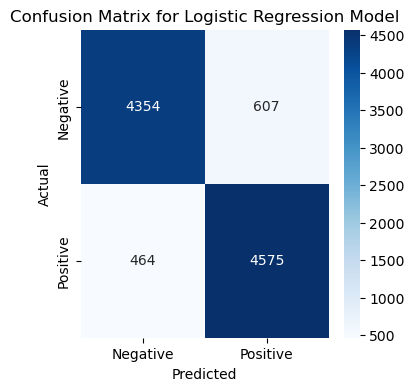

In [89]:
# Generating confusion matrix
lr_confusion_matrix = confusion_matrix(y_test, y_pred_logreg)

# Plotting confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(lr_confusion_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# Setting labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression Model')

# Displaying plot
plt.show()

#### Observation:
1. True positive and True negative values are very close the total actual positive and total actual negative values.
2. Out of 4961 Actual negative reviews, the model has predicted 4354 negative reviews correctly, indicating that the model is performing well on unseen  negative reviews.
3. Out of 5039 Actual positive reviews, the model has predicted 4575 positive reviews correctly, indicating that the model is performing well on unseen positive reviews.
4. As the TP and TN values are high, it states that the model is reliable and can make very good prediction on future movie reviews.
5. So, IMDB can rely on this model for its future movie reviews.

In [91]:
# Creating pre processing text function
def preprocessing_text(new_review):
    # Converting all the reviews to lowercase
    new_review = new_review.lower()

    # Removing special characters and punctuation
    new_review = re.sub(r'[^a-z\s]', '', new_review) 

    # Applying tokenisation
    new_review = word_tokenize(new_review)

    # Removing any extra spaces in each word of the new_review
    new_review = [word.strip() for word in new_review]

    # Removing stopwords from new_review
    new_review = [word for word in new_review if word not in stop_words]

    # Applying Lemmatization
    lemmatizer = WordNetLemmatizer()
    new_review = [lemmatizer.lemmatize(word) for word in new_review]

    # Joining input review
    processed_review = ' '.join(new_review)

    return processed_review


In [92]:
# Creating predict_sentiment function
def predict_sentiment(input_review, review_length, word_count, char_count, avg_word_length):
    # Preprocess the review (extracting the first review from the list)
    preprocessed_review = preprocessing_text(input_review[0])

    # Creating dataFrame for the new review with the additional features
    new_data = pd.DataFrame({
        'review': [preprocessed_review],
        'review_length': [review_length],
        'word_count': [word_count],
        'char_count': [char_count],
        'avg_word_length': [avg_word_length]
    })

    # Transforming reviews using the vectorizer
    reviews_tfidf = vectorizer.transform(new_data['review'])

    # Combining transformed TF-IDF features with the additional features
    additional_features = new_data[['review_length', 'word_count', 'char_count', 'avg_word_length']].values
    combined_features = hstack([reviews_tfidf, additional_features])

    # Predicting sentiment using the logreg_model
    predictions = logreg_model.predict(combined_features)

    # Returning sentiment
    return '\nIt is a Positive Review' if predictions[0] == 1 else '\nIt is a Negative Review'


#### Sample Movie Review

In [150]:
# Taking new review from user
user_review=input("Enter new review\n")

review_length = len(user_review.split())
word_count = len(user_review.split())
char_count = len(user_review)
avg_word_length = char_count / word_count if word_count > 0 else 0

# Calling predict_sentiment function
print(predict_sentiment([user_review], review_length, word_count, char_count, avg_word_length))

Enter new review
 "The Secret Life of Walter Mitty" is a heartwarming journey that inspires viewers to embrace adventure and self-discovery. Ben Stiller's direction and performance bring this uplifting tale to life.



It is a Positive Review


# Final Insights:
1. IMDB movie review dataset is a large dataset with 50k records of reviews and sentiment for each review.
2. Have trained the dataset with Logistic Regression, Random Forest and SVM algorithms.
3. Among these algorithms, Logistic Regression Algorithm works better as it has accuracy value of 88.86% .
4. This indicates that the model is able to predict the new or unseen data correctly 88.86 of times.
5. From confusion matrix, we observe a high values for true positives and true negatives. This implies that the model is correctly predicting positive review and negative review of IMDB.
6. So, we can completely rely on this model for future or unseen movie reviews of IMDB.